# Sentiment Analysis with Hugging Face

Hugging Face is an open-source and platform provider of machine learning technologies. You can use install their package to access some interesting pre-built models to use them directly or to fine-tune (retrain it on your dataset leveraging the prior knowledge coming with the first training), then host your trained models on the platform, so that you may use them later on other devices and apps.

Please, [go to the website and sign-in](https://huggingface.co/) to access all the features of the platform.

[Read more about Text classification with Hugging Face](https://huggingface.co/tasks/text-classification)

The Hugging face models are Deep Learning based, so will need a lot of computational GPU power to train them. Please use [Colab](https://colab.research.google.com/) to do it, or your other GPU cloud provider, or a local machine having NVIDIA GPU.

## Application of Hugging Face Text classification model Fune-tuning

Find below a simple example, with just `3 epochs of fine-tuning`.

Read more about the fine-tuning concept : [here](https://deeplizard.com/learn/video/5T-iXNNiwIs#:~:text=Fine%2Dtuning%20is%20a%20way,perform%20a%20second%20similar%20task.)

In [1]:
!pip install datasets
!pip install accelerate>=0.20.1
!pip install transformers[torch]
!pip install -U huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 61.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 105.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 35.4 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.18.0
    Uninstalling huggingface-hub-0.18.0:
      Successfully uninstalled huggingface-hub-0.18.0
  Using cached huggingface_hub-0.18.0-py3-none-any.whl (301 kB)
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.17

In [2]:
!pip install tokenizers --upgrade


  Using cached huggingface_hub-0.17.3-py3-none-any.whl (295 kB)
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.18.0
    Uninstalling huggingface-hub-0.18.0:
      Successfully uninstalled huggingface-hub-0.18.0


In [3]:
import os
import pandas as pd
from datasets import load_dataset
from datasets import load_metric
from sklearn.model_selection import train_test_split
from google.colab import drive
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [4]:
from transformers import AutoTokenizer, AutoConfig
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
from transformers import Trainer
from transformers import DataCollatorWithPadding
from transformers import TFAutoModelForSequenceClassification
from scipy.special import softmax

In [5]:
import torch
from huggingface_hub import notebook_login
import numpy as np

In [14]:
notebook_login()

In [6]:
# Set a fixed random seed for PyTorch on CPU
torch.manual_seed(42)

# Control the seed for individual GPU operations (optional)
if torch.cuda.is_available:
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  torch.cuda.manual_seed_all(42)


In [7]:
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Disabe W&B
os.environ["WANDB_DISABLED"] = "true"

In [9]:
# Load the dataset and display some values
df = pd.read_csv('/content/drive/MyDrive/Covid-19 tweet dataset/Train.csv')

# A way to eliminate rows containing NaN values
df = df[~df.isna().any(axis=1)]


In [10]:
df.head(10)

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.000000
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.000000
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.000000
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.000000
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.000000
5,OVNPOAUX,<user> a nearly 67 year old study when mental ...,1.0,0.666667
6,JDA2QDV5,"Study of more than 95,000 kids finds no link b...",1.0,0.666667
7,S6UKR4OJ,psa: VACCINATE YOUR FUCKING KIDS,1.0,1.000000
8,V6IJATBE,Coughing extra on the shuttle and everyone thi...,1.0,0.666667
9,VB25IDQK,AIDS vaccine created at Oregon Health &amp; Sc...,1.0,0.666667


In [9]:
df.describe()

,label,agreement
count,9999.00000,9999.000000
mean,0.30153,0.854252
std,0.64674,0.180707
min,-1.00000,0.333333
25%,0.00000,0.666667
50%,0.00000,1.000000
75%,1.00000,1.000000
max,1.00000,1.000000


In [10]:
df.isna().sum()

tweet_id     0
safe_text    0
label        0
agreement    0
dtype: int64

#### How many positive ,negative and neutral

In [11]:
df.label.value_counts()

 0.0    4908
 1.0    4053
-1.0    1038
Name: label, dtype: int64

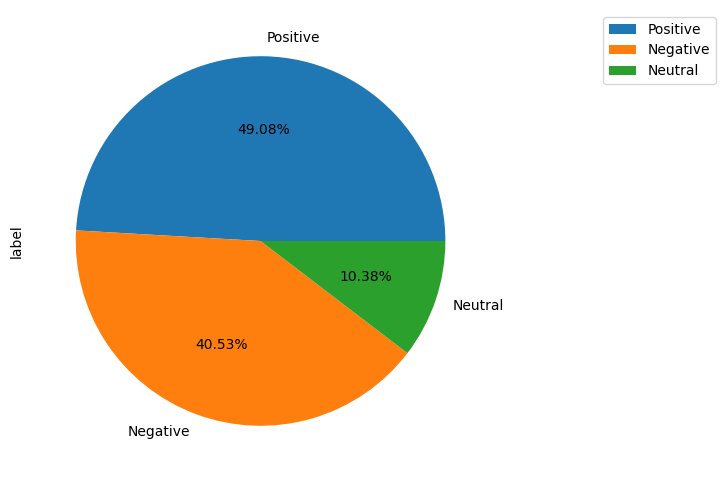

In [12]:
plt.figure(figsize=(6,6))
explode=0.1,0
df.label.value_counts().plot.pie(autopct='%1.2f%%',labels=['Positive','Negative','Neutral'])
plt.legend(bbox_to_anchor=(1.5,1))
plt.show()

In [13]:
# check dtypes

df.dtypes

tweet_id      object
safe_text     object
label        float64
agreement    float64
dtype: object

(-0.5, 399.5, 199.5, -0.5)

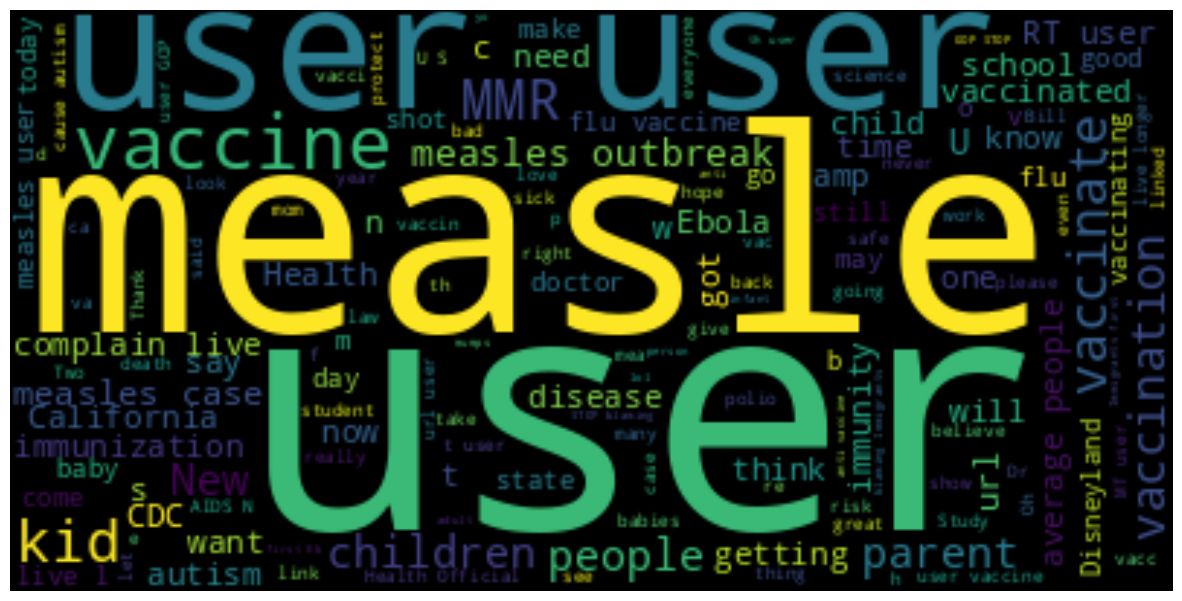

In [15]:
all_data = df['safe_text'].to_string()
wordcloud =WordCloud().generate(all_data)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")

I manually split the training set to have a training subset ( a dataset the model will learn on), and an evaluation subset ( a dataset the model with use to compute metric scores to help use to avoid some training problems like [the overfitting](https://www.ibm.com/cloud/learn/overfitting) one ).

There are multiple ways to do split the dataset. You'll see two commented line showing you another one.

In [16]:
# Split the train data => {train, eval}
train, eval = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

In [17]:
train.head()

,tweet_id,safe_text,label,agreement
9305,YMRMEDME,Mickey's Measles has gone international <url>,0.0,1.000000
3907,5GV8NEZS,S1256 [NEW] Extends exemption from charitable ...,0.0,1.000000
795,EI10PS46,<user> your ignorance on vaccines isn't just ...,1.0,0.666667
5793,OM26E6DG,Pakistan partly suspends polio vaccination pro...,0.0,1.000000
3431,NBBY86FX,In other news I've gone up like 1000 mmr,0.0,1.000000


In [18]:
eval.head()

,tweet_id,safe_text,label,agreement
6571,R7JPIFN7,Children's Museum of Houston to Offer Free Vac...,1.0,1.000000
1754,2DD250VN,<user> no. I was properly immunized prior to t...,1.0,1.000000
3325,ESEVBTFN,<user> thx for posting vaccinations are impera...,1.0,1.000000
1485,S17ZU0LC,This Baby Is Exactly Why Everyone Needs To Vac...,1.0,0.666667
4175,IIN5D33V,"Meeting tonight, 8:30pm in room 322 of the stu...",1.0,1.000000


In [19]:
print(f"new dataframe shapes: train is {train.shape}, eval is {eval.shape}")

new dataframe shapes: train is (7999, 4), eval is (2000, 4)


In [20]:
# Save splitted subsets
train.to_csv("/content/drive/MyDrive/Covid-19 tweet dataset/train_subset", index=False)
eval.to_csv("/content/drive/MyDrive/Covid-19 tweet dataset/eval_subset", index=False)

In [11]:
dataset = load_dataset('csv',
                        data_files={'train': '/content/drive/MyDrive/Covid-19 tweet dataset/train_subset',
                        'eval': '/content/drive/MyDrive/Covid-19 tweet dataset/eval_subset'}, encoding = "ISO-8859-1")


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

In [12]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [13]:
def transform_labels(label):

    label = label['label']
    num = 0
    if label == -1: #'Negative'
        num = 0
    elif label == 0: #'Neutral'
        num = 1
    elif label == 1: #'Positive'
        num = 2

    return {'labels': num}

def tokenize_data(example):
    return tokenizer(example['safe_text'], padding='max_length', truncation=True, max_length=256)

In [15]:
# Change the tweets to tokens that the models can exploit
dataset = dataset.map(tokenize_data, batched=True)

# Transform	labels and remove the useless columns
remove_columns = ['tweet_id', 'label', 'safe_text', 'agreement']
dataset = dataset.map(transform_labels, remove_columns=remove_columns)

Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [16]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 7999
    })
    eval: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2000
    })
})

In [ ]:
# dataset['train']

In [18]:
# Configure the trianing parameters like `num_train_epochs`:
# the number of time the model will repeat the training loop over the dataset
training_args = TrainingArguments("sentiment_analysis_model_trainer",
    num_train_epochs=8,
    load_best_model_at_end=True,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    push_to_hub=True)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [19]:
# evaluation metrics

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

<ipython-input-19-ce8e5b3f167f>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [20]:
train_dataset = dataset['train'].shuffle(seed=10) #.select(range(40000)) # to select a part
eval_dataset = dataset['eval'].shuffle(seed=10)

## other way to split the train set ... in the range you must use:
# # int(num_rows*.8 ) for [0 - 80%] and  int(num_rows*.8 ),num_rows for the 20% ([80 - 100%])
# train_dataset = dataset['train'].shuffle(seed=10).select(range(40000))
# eval_dataset = dataset['train'].shuffle(seed=10).select(range(40000, 41000))

In [21]:
# Loading a pretrain model while specifying the number of labels in our dataset for fine-tuning
model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=3)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [22]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer,padding='max_length', max_length=256, return_tensors='pt')

In [23]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

In [24]:
# Launch the learning process: training
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.622400,0.692336,0.764000
2,0.514400,0.711963,0.783500
3,0.385000,0.870072,0.775500


Epoch,Training Loss,Validation Loss,Accuracy
1,0.622400,0.692336,0.764000
2,0.514400,0.711963,0.783500
3,0.385000,0.870072,0.775500
4,0.294100,1.052805,0.776000
5,0.198200,1.293399,0.782500
6,0.121200,1.423759,0.779000
7,0.064600,1.662622,0.779000
8,0.051500,1.741906,0.777500


TrainOutput(global_step=8000, training_loss=0.280697491645813, metrics={'train_runtime': 3122.2107, 'train_samples_per_second': 20.496, 'train_steps_per_second': 2.562, 'total_flos': 8418576913625088.0, 'train_loss': 0.280697491645813, 'epoch': 8.0})

In [25]:
# Launch the final evaluation
trainer.evaluate()

{'eval_loss': 0.6923360824584961,
 'eval_accuracy': 0.764,
 'eval_runtime': 29.7928,
 'eval_samples_per_second': 67.13,
 'eval_steps_per_second': 8.391,
 'epoch': 8.0}

In [27]:
trainer.push_to_hub()

'https://huggingface.co/Azie88/sentiment_analysis_model_trainer/tree/main/'

Some checkpoints of the model are automatically saved locally in `test_trainer/` during the training.

You may also upload the model on the Hugging Face Platform... [Read more](https://huggingface.co/docs/hub/models-uploading)

This notebook is inspired by an article: [Fine-Tuning Bert for Tweets Classification ft. Hugging Face](https://medium.com/mlearning-ai/fine-tuning-bert-for-tweets-classification-ft-hugging-face-8afebadd5dbf)

Do not hesitaite to read more and to ask questions, the Learning is a lifelong activity.

In [28]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)

model_path = f"Azie88/sentiment_analysis_model_trainer"
config = AutoConfig.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

In [29]:
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [30]:
# Input preprocessing
text = "Covid cases are increasing fast!"
text = preprocess(text)

In [31]:
# PyTorch-based models
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)
scores = output[0][0].detach().numpy()
scores = softmax(scores)

In [32]:
config.id2label = {0: 'NEGATIVE', 1: 'NEUTRAL', 2: 'POSITIVE'}

In [33]:
# Print labels and scores
ranking = np.argsort(scores)
ranking = ranking[::-1]
for i in range(scores.shape[0]):
    l = config.id2label[ranking[i]]
    s = scores[ranking[i]]
    print(f"{i+1}) {l} {np.round(float(s), 4)}")

1) NEUTRAL 0.9755
2) POSITIVE 0.0225
3) NEGATIVE 0.002
